In [1]:
import networkx as nx
from glob import glob
import re
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd; pd.options.display.float_format = '{:,.2f}'.format
import statsmodels.stats.api as sm
import warnings; warnings.filterwarnings("ignore", category=UserWarning)
from statistics import median_low

In [2]:
import sys
import os

sys.path.extend(['./..'])  # have to add the project path manually to the Python path
os.chdir('./..')

In [3]:
pwd

'/home/ssikdar/infinity-mirror'

In [4]:
from src.utils import load_pickle
from src.Tree import TreeNode

In [5]:
%matplotlib inline

In [7]:
def get_stats_from_root(name, model, sel, root, cols, trial_id):
    for tnode in root.descendants:
        row = {}
        row['name'] = name
        
        row['orig_n'] = root.graph.order()
        row['orig_m'] = root.graph.size()
#         row['orig_graph_obj'] = root.graph
        
        row['model'] = model
        row['sel'] = sel
        row['trial_id'] = trial_id
        
        row['gen_id'] = tnode.depth
        row['gen_n'] = tnode.graph.order()
        row['gen_m'] = tnode.graph.size()
#         row['gen_graph_obj'] = tnode.graph
        
        stats = tnode.stats
        assert set(cols[-12: -4]) == set(stats.keys()), f'tnode: {stats.keys()} doesnt have all the reqd stats'
        for key, val in stats.items():
            row[key] = val
        
        robustness = tnode.robustness
#         print(tnode.robustness)
        if robustness is None:
#             print('Robustness stats not found for', root)
            for key in cols[-4: ]:
                row[key] = None
        else:
            robustness.pop('n', None)
            robustness.pop('m', None)
            assert set(cols[-4: ]) == set(robustness.keys()), f'tnode: {robustness.keys()} doesnt have all the req robustness stats'
            for key, val in robustness.items():
                row[key] = val
            
        assert len(row.keys()) == len(cols), \
        f'Imporper number of cols in row: {len(row)}: expected {len(cols)} {stats.keys()}'
        
        yield row
    

In [16]:
base_filename = '/data/dgonza26/'
# name = 'grid-10-10'
name = 'tree'

N = 20  # number of total time steps
T = 50  # number of trials

cols = ['name', 'orig_n', 'orig_m', #'orig_graph_obj', 
        'model', 'sel', 'trial_id',
        'gen_id', 'gen_n', 'gen_m', #'gen_graph_obj',
        'deltacon0', 'lambda_dist', 'degree_cvm', 'pagerank_cvm', 
        'pgd_pearson', 'pgd_spearman', 'node_diff', 'edge_diff',
        'num_components', 'giant_frac', 'num_clusters', 'modularity']

data = {col: [] for col in cols}

models = ('CNRG', 'SBM', 'Chung-Lu', 'BTER', 'Erdos-Renyi', 'GraphAE', 'GraphVAE', 'BUGGE', 'NetGAN')

fail_count = 0
sel = 'fast'
for model in models:
    for trial_id in range(1, T+1):
        path_re = f'{base_filename}/{name}/{model}/{sel}_{N}_{trial_id}_augmented.pkl.gz'
        try:
            root_pickle_path = glob(path_re)[0]
        except IndexError:
            print(f'skipping {model}', end='; ')
            continue
        print('reading ', '/'.join(root_pickle_path.split('/')[-2:]), end=' ', flush=True)

        if 'failed' in root_pickle_path:
            print(f'Infinity mirror failed for {root_pickle_path}! Skipping')
            fail_count += 1
            continue

        root = load_pickle(root_pickle_path)
        for row in get_stats_from_root(name=name, model=model, sel=sel, root=root, 
                                    cols=cols, trial_id=trial_id):
            for col, val in row.items():
                data[col].append(val)
#             print(row)
    print('\n\n')

df = pd.DataFrame(data)
df.to_csv(f'./analysis/csv/{name}.csv')

reading  CNRG/fast_20_1_augmented.pkl.gz reading  CNRG/fast_20_2_augmented.pkl.gz reading  CNRG/fast_20_3_augmented.pkl.gz reading  CNRG/fast_20_4_augmented.pkl.gz reading  CNRG/fast_20_5_augmented.pkl.gz reading  CNRG/fast_20_6_augmented.pkl.gz reading  CNRG/fast_20_7_augmented.pkl.gz reading  CNRG/fast_20_8_augmented.pkl.gz reading  CNRG/fast_20_9_augmented.pkl.gz reading  CNRG/fast_20_10_augmented.pkl.gz reading  CNRG/fast_20_11_augmented.pkl.gz reading  CNRG/fast_20_12_augmented.pkl.gz reading  CNRG/fast_20_13_augmented.pkl.gz reading  CNRG/fast_20_14_augmented.pkl.gz reading  CNRG/fast_20_15_augmented.pkl.gz reading  CNRG/fast_20_16_augmented.pkl.gz reading  CNRG/fast_20_17_augmented.pkl.gz reading  CNRG/fast_20_18_augmented.pkl.gz reading  CNRG/fast_20_19_augmented.pkl.gz reading  CNRG/fast_20_20_augmented.pkl.gz reading  CNRG/fast_20_21_augmented.pkl.gz reading  CNRG/fast_20_22_augmented.pkl.gz reading  CNRG/fast_20_23_augmented.pkl.gz reading  CNRG/fast_20_24_augmented.pkl.gz r

In [17]:
df2 = pd.read_csv('./analysis/csv/tree.csv', index_col=0)
df2.head()

,name,orig_n,orig_m,model,sel,trial_id,gen_id,gen_n,gen_m,deltacon0,...,degree_cvm,pagerank_cvm,pgd_pearson,pgd_spearman,node_diff,edge_diff,num_components,giant_frac,num_clusters,modularity
0,tree,2955,2954,CNRG,fast,1,1,2935,2934,"14,073.63",...,0.12,0.05,0.00,0.00,20.00,20.00,1,1.00,59,0.96
1,tree,2955,2954,CNRG,fast,1,2,2934,2933,"14,157.30",...,0.12,0.05,0.00,0.00,21.00,21.00,1,1.00,55,0.96
2,tree,2955,2954,CNRG,fast,1,3,2961,2960,"14,236.38",...,0.12,0.06,0.00,0.00,6.00,6.00,1,1.00,56,0.96
3,tree,2955,2954,CNRG,fast,1,4,2981,2980,"14,301.56",...,0.19,0.13,0.00,0.00,26.00,26.00,1,1.00,55,0.96
4,tree,2955,2954,CNRG,fast,1,5,3009,3008,"14,386.32",...,0.19,0.19,0.00,0.00,54.00,54.00,1,1.00,59,0.96


In [ ]:
df

In [ ]:
# for model in ('CNRG', 'SBM', 'Chung-Lu', 'BTER', 'Erdos-Renyi', 'GraphAE', 'GraphVAE', 'NetGAN', 'BUGGE', 'LinearAE', 'HRG'):
for model in ('BTER',):
    try:
        root = load_pickle(f'/data/dgonza26/flights/{model}/fast_20_4_augmented.pkl.gz')
        print(root, model, root.children[0].robustness)
    except:
        pass

In [18]:
df.model.unique() 

array(['CNRG', 'SBM', 'Chung-Lu', 'BTER', 'Erdos-Renyi', 'BUGGE'],
      dtype=object)

In [19]:
def group_plot(df):
    name = df.name.unique()[0]
    metrics = ['node_diff', 'edge_diff', 'lambda_dist', 'deltacon0', 'degree_cvm']#, 'pgd_spearman']
    metrics.extend(['num_components', 'giant_frac', 'num_clusters', 'modularity'])
    rows = len(metrics)
    
    models = df.model.unique() # ['CNRG', 'SBM', 'Chung-Lu', 'BTER']
    cols = len(models)

    n_d_min = min(df[df.model==model].node_diff.min() for model in models) - 1
    n_d_max = max(df[df.model==model].node_diff.max() for model in models) + 5
    
    e_d_min = min(df[df.model==model].edge_diff.min() for model in models) - 1
    e_d_max = max(df[df.model==model].edge_diff.max() for model in models) + 5
    
    l_d_min = min(df[df.model==model].lambda_dist.min() for model in models) - 0.1
    l_d_max = max(df[df.model==model].lambda_dist.max() for model in models) + 0.15
    
    dc0_min = min(df[df.model==model].deltacon0.min() for model in models) - 100
    dc0_max = max(df[df.model==model].deltacon0.max() for model in models) + 100
    
    p_sp_min = min(df[df.model==model].pgd_spearman.min() for model in models) - 0.1
    p_sp_max = max(df[df.model==model].pgd_spearman.max() for model in models) + 0.15
    
    d_min = min(df[df.model==model].degree_cvm.min() for model in models) - 0.1
    d_max = max(df[df.model==model].degree_cvm.max() for model in models) + 0.15
    
    comp_min = min(df[df.model==model].num_components.min() for model in models) - 6
    comp_max = max(df[df.model==model].num_components.max() for model in models) + 5
    
    gf_min = -0.05
    gf_max = 1.1
    
    clu_min = min(df[df.model==model].num_clusters.min() for model in models) - 1
    clu_max = max(df[df.model==model].num_clusters.max() for model in models) + 5
    
    mod_min = min(df[df.model==model].modularity.min() for model in models) - 0.1
    mod_max = max(df[df.model==model].modularity.max() for model in models) + 0.15
    
    plt.rcParams['figure.figsize'] = [25, 15]
#     print(rows, cols)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=True)

    for i in range(rows):
        for j in range(cols):
            ax = axes[i, j]
            metric = metrics[i]
            model = models[j]
            filtered_df = df[df.model==model]
            
            if i == 0 and j == 0:
                legend_style = 'brief'
            else:
                legend_style = ''
            
            sns.lineplot(x='gen_id', y=metric, ax=ax, data=filtered_df, 
                         hue='sel', marker='o', ci=99, err_style='band', legend=legend_style);
            
            ax.set_xlim((0.5, 20.5))
            
            if metric == 'node_diff':
                ax.set_ylim((n_d_min, n_d_max))
            elif metric == 'edge_diff':
                ax.set_ylim((e_d_min, e_d_max))
            elif metric == 'lambda_dist':
                ax.set_ylim((l_d_min, l_d_max))
            elif metric == 'deltacon0':
                ax.set_ylim((dc0_min, dc0_max))
            elif metric == 'pgd_spearman':
                ax.set_ylim((p_sp_min, p_sp_max))
            elif metric == 'degree_cvm':
                ax.set_ylim((d_min, d_max))
            elif metric == 'num_components':
                ax.set_ylim((comp_min, comp_max))
            elif metric == 'giant_frac':
                ax.set_ylim((gf_min, gf_max))
            elif metric == 'num_clusters':
                ax.set_ylim((clu_min, clu_max))
            elif metric == 'modularity':
                ax.set_ylim((mod_min, mod_max))            
                
            if j == 0:
                ax.set_ylabel(metric)
            else:
                ax.set_ylabel('')
                
            if i == 0:
                ax.set_title(model)
            else:
                ax.set_title('')
                
            if i == rows - 1:
                ax.set_xlabel('gen_id')
            else:
                ax.set_xlabel('')
            
    plt.suptitle(f'{name}', y=1.01);
    plt.tight_layout()
    plt.savefig(f'./analysis/figures/{name}-stats-robustness.png', dpi=300, bbox_inches='tight')

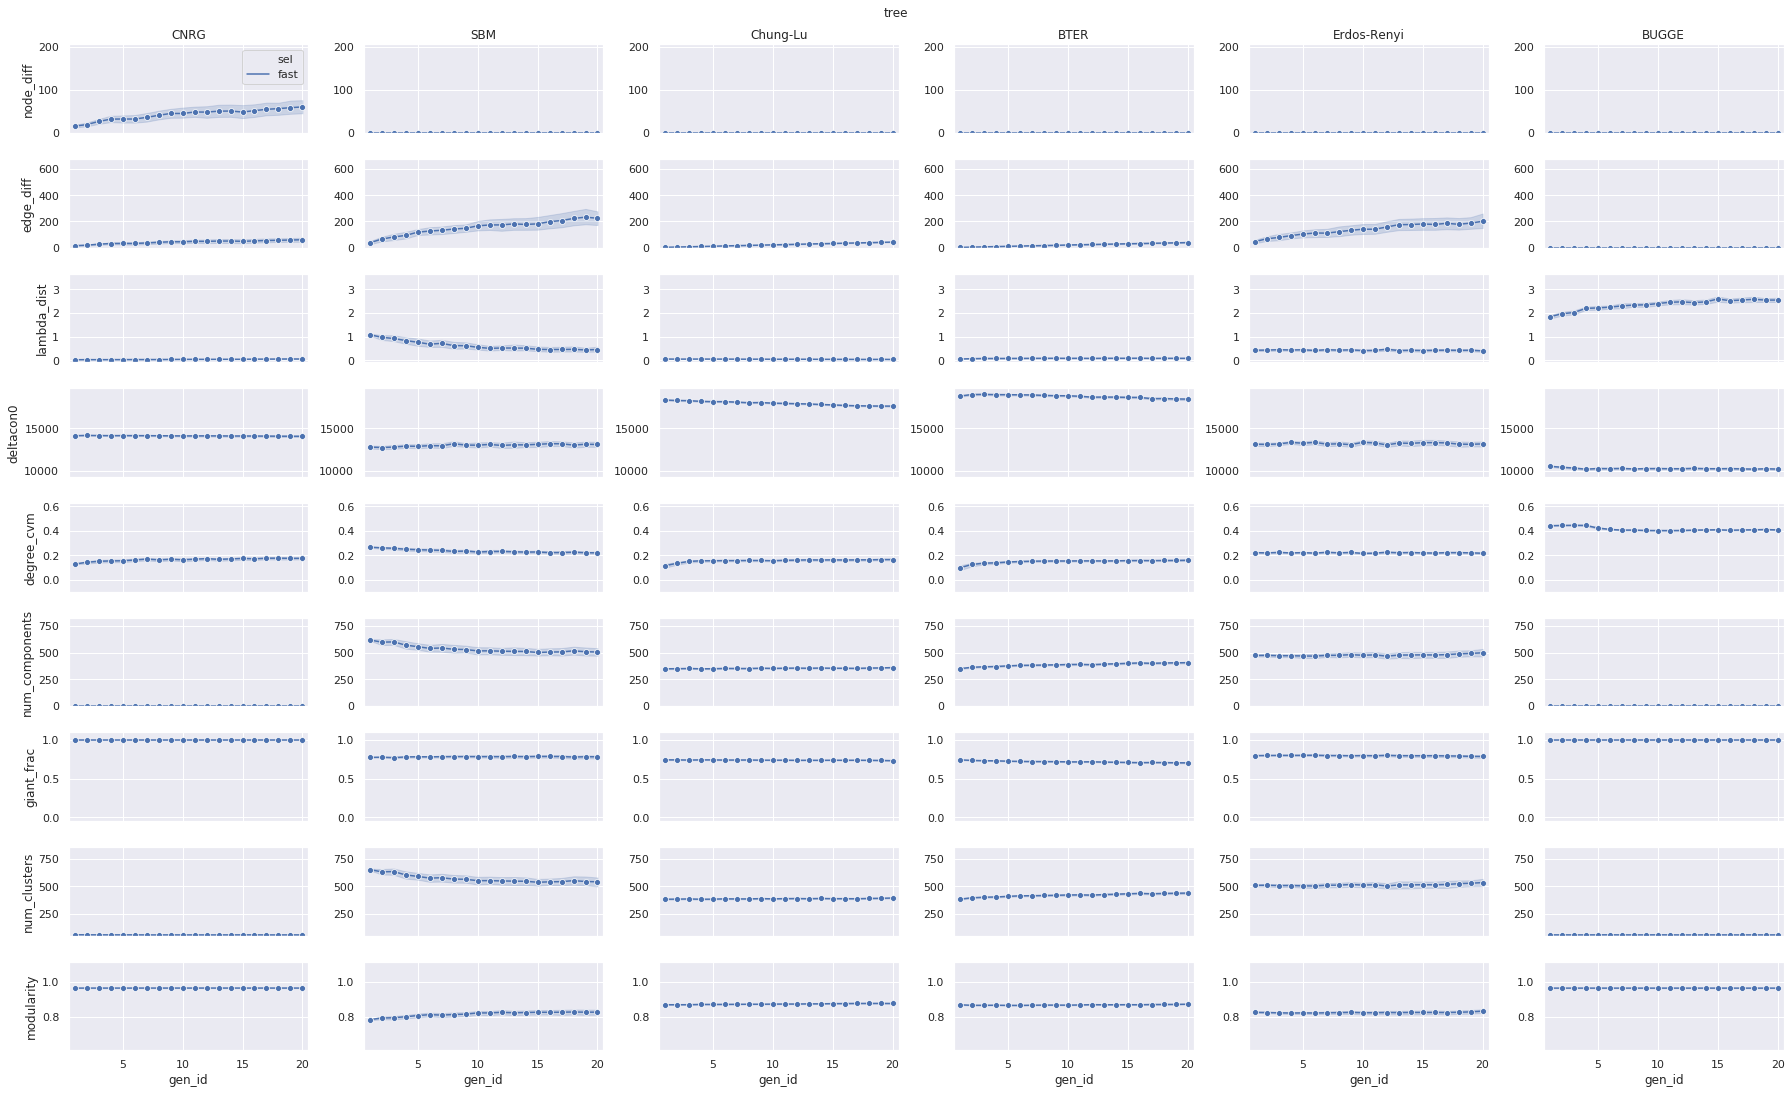

In [20]:
group_plot(df)